### Prediction using Nonlinear Vector Autoregression (NVAR)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import scipy.optimize
import sys
import warnings

from NVAR import *
from utils import RMSE

np.set_printoptions(edgeitems=10, linewidth=100000, threshold=sys.maxsize)
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

1+𝑘𝑑+𝑘𝑑(𝑘𝑑+1)∕2 rows, training length columns \
w H where w is weights row vector and H is column matrix

In [2]:
# 
# [w1, w2, w3, w4, w5, w6] [1       , 1, 1]
#                          [xt      ,  ,  ]
#                          [xt-1    ,  ,  ]
#                          [xt^2    ,  ,  ]
#                          [xt*xt-1 ,  ,  ]
#                          [xt-1^2  ,  ,  ]

# mg     : 15000 total, 1,000 pre-train, 11,000 training, 3,000 testing
# lorenz : 10000 total,   500 pre-train,  7,500 training, 2,000 testing

# 1 + kd + 1/2*k^2d^2 + 1/2*kd = 100
# 1/2*k^2*d^2+3/2*k*d+1 = 100
# 1/2*k^2*d^2+3/2*k*d-99 = 0
# given d (fixed by dataset; mg=1, lorenz=3), solve for k to maximize 1+kd+kd(kd+1)/2 <= network size of comparable approaches. (100 in base case)

In [3]:
d = 1
network_size = 100
coeff = [1/2*d**2, 3/2*d, 1-network_size]
np.roots(coeff)

array([-15.6509717,  12.6509717])

In [4]:
d_mg = 3
network_size = 100
coeff_mg = [1/2*d_mg**2, 3/2*d_mg, 1-network_size]
np.roots(coeff_mg)

array([-5.21699057,  4.21699057])

In [5]:
print("d=1:")
print(f'rows= {nvar_rows(1, 12)}')
print("d=3:")
print(f'rows= {nvar_rows(3, 4)}')

d=1:
rows= 91
d=3:
rows= 91


#### Mackey-Glass

15000 total, 1,000 pre-train, 11,000 training, 3,000 testing

In [6]:
mg_gval = 0.25

mg = np.loadtxt(f'./datasets/py-mackey-glass_g={mg_gval:.02f}.csv', delimiter=",", dtype='float64')

data = mg[:,1:]
target = mg[1:,1:]

# data = mg_normed[:,1:]
# target = mg_normed[1:,1:]

# data = mg_scaled[:,1:]
# target = mg_scaled[1:,1:]

# data = mg_scaled_pos[:,1:]
# target = mg_scaled_pos[1:,1:]

# data = np.column_stack([
#     mg[:,1:],
#     np.vstack([
#         0, mg[:-1,1:]
#     ]),
#     np.vstack([
#         0, 0, mg[:-2,1:]
#     ])
# ])
# target = data[1:,:]

# k=2
# k=3
# k=4
# k=5
# k=6
# k=7
# k=8
k=12
# k=16
# k=17
# k=30

train_start=1000
train_end=12000
test_start=train_end
test_end=15000

# train_start=1000
# train_end=12000
# test_start=8000
# test_end=10000

training_target = target[train_start:train_end]
test_target = target[test_start:test_end]
train_indices = np.arange(train_start,train_end)
test_indices = np.arange(test_start,test_end)

In [7]:
model_arr = []
s_grid = [2,3,4,5,6,7,8,10,15,20,25,30]
reg_grid = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
one_step_rmse_arr = []
recursive_rmse_arr = []
for s in s_grid:
    for r in reg_grid:
        model = NVARModel(k, s, r)
        model.train(data, target, train_indices)
        one_step_rmse_arr.append(model.evaluate(data, target, test_indices))
        recursive_rmse_arr.append(RMSE(test_target,model.recursive_predict(data, train_start, train_end, test_end-test_start)))
        model_arr.append(model)
one_step_rmse_arr = np.array(one_step_rmse_arr)
recursive_rmse_arr = np.array(recursive_rmse_arr)
best_one_step_idx = np.argmin(one_step_rmse_arr)
best_one_step_model = model_arr[best_one_step_idx]
best_recursive_idx = np.argmin(recursive_rmse_arr[~np.isnan(recursive_rmse_arr)])
best_recursive_model = [model_arr[i] for i in range(len(model_arr)) if ~np.isnan(recursive_rmse_arr)[i]][best_recursive_idx]
print(f'best one step params')
print(f'k  :{best_one_step_model.k}')
print(f's  :{best_one_step_model.s}')
print(f'reg:{best_one_step_model.reg}')
print(f'best recursive params')
print(f'k  :{best_recursive_model.k}')
print(f's  :{best_recursive_model.s}')
print(f'reg:{best_recursive_model.reg}')

/Users/samuelhocking/Files/Research/math/SciML/Code/chaotic-ml/NVAR.py:13: RuntimeWarning: overflow encountered in multiply
  [lin[i]*lin[i:,:] for i in range(len(lin))]
/Users/samuelhocking/Files/Research/math/SciML/Code/chaotic-ml/NVAR.py:51: RuntimeWarning: invalid value encountered in matmul
  y = state_vect.T @ self.w


best one step params
k  :12
s  :2
reg:1e-07
best recursive params
k  :12
s  :3
reg:0.1


In [8]:
best_one_step_model.w.shape

(91, 1)

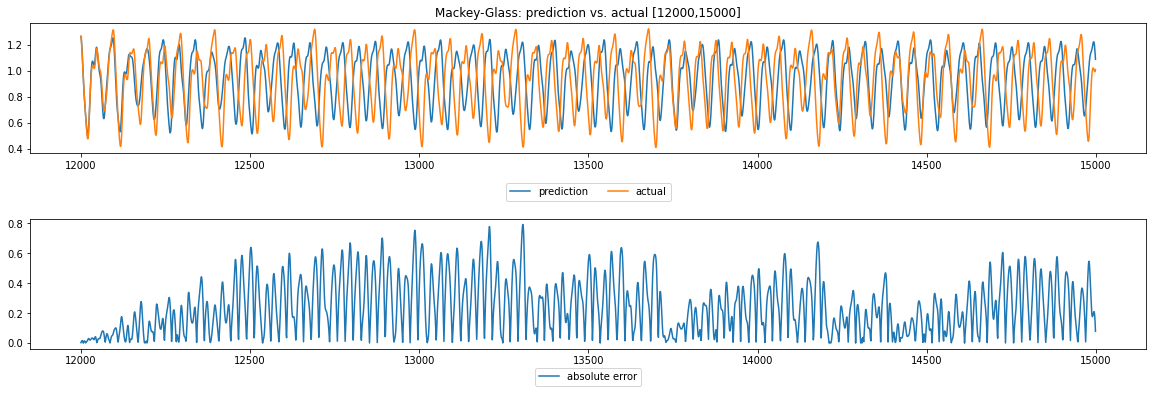

In [9]:
recursive_out = best_recursive_model.recursive_predict(data, train_start, test_start, test_end-test_start)
# recursive_out = best_one_step_model.recursive_predict(data, train_start, test_start, test_end-test_start)
data_end = test_start
t_forward = test_end-test_start

fig, axs = plt.subplots(2, figsize=(20, 6))
axs[0].plot(np.arange(data_end,data_end+t_forward), recursive_out[:,0], label="prediction")
axs[0].plot(np.arange(data_end,data_end+t_forward), data[data_end:data_end+t_forward,0], label="actual")
axs[1].plot(np.arange(data_end,data_end+t_forward), np.abs(recursive_out[:,0]-data[data_end:data_end+t_forward,0]), label="absolute error")
axs[0].legend(loc="lower center", ncol=2, bbox_to_anchor=(0.5,-0.4))
axs[1].legend(loc="lower center", ncol=2, bbox_to_anchor=(0.5,-0.32))
axs[0].set_title(f'Mackey-Glass: prediction vs. actual [{data_end},{data_end+t_forward}]')
plt.subplots_adjust(hspace=0.5)
plt.show()
# fig.savefig(f'./images/mackey-glass-recursive_tau={mg_gval}_k={best_recursive_model.k}_s={best_recursive_model.s}_reg={best_recursive_model.reg}_[{data_end},{data_end+t_forward}].png',facecolor='white', transparent=False)

In [10]:
RMSE(test_target, recursive_out)

0.3008486009912305

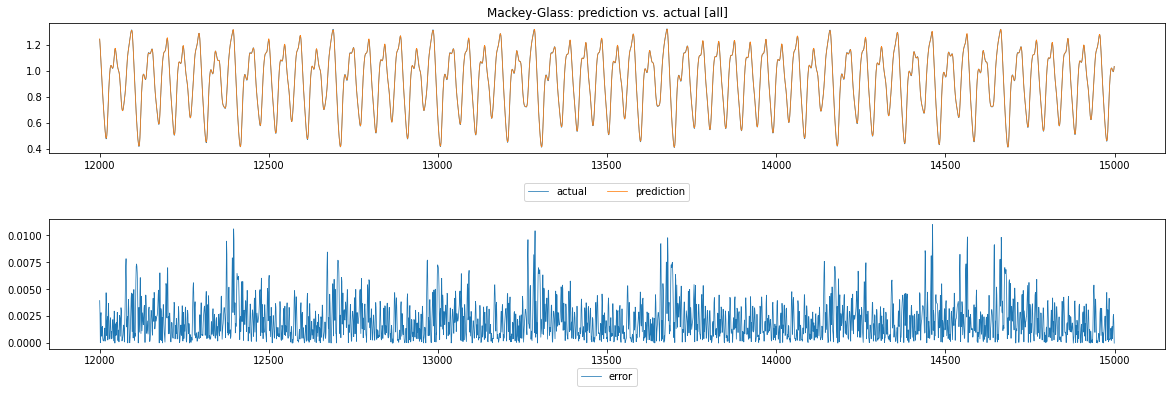

In [11]:
test_out = best_recursive_model.test_out

fig, axs = plt.subplots(2, figsize=(20, 6))
axs[0].plot(np.arange(test_start,test_end), test_target[:,0], linewidth=0.75, label="actual")
axs[0].plot(np.arange(test_start,test_end), test_out[:,0], linewidth=0.75, label="prediction")
axs[1].plot(np.arange(test_start,test_end), np.abs(test_out[:,0]-test_target[:,0]), linewidth=0.75, label="error")
axs[0].legend(loc="lower center", ncol=2, bbox_to_anchor=(0.5,-0.4))
axs[1].legend(loc="lower center", ncol=2, bbox_to_anchor=(0.5,-0.32))
axs[0].set_title('Mackey-Glass: prediction vs. actual [all]')
plt.subplots_adjust(hspace=0.5)
plt.show()
# fig.savefig(f'mackey-glass-one-step_tau={mg_gval}_k={k}_s={mg_s_star}_reg={mg_reg_star}.png',facecolor='white', transparent=False)

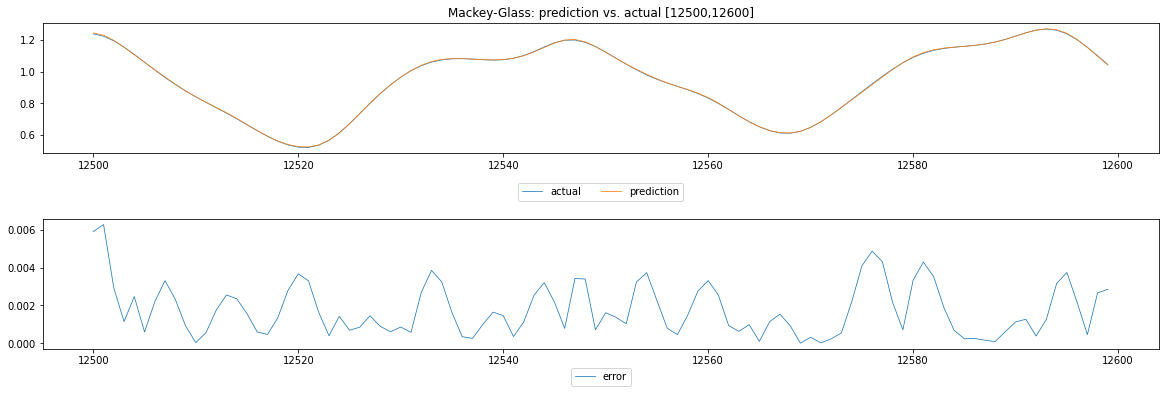

In [12]:
start = 12500
pts_to_show = 100
fig, axs = plt.subplots(2, figsize=(20, 6))
axs[0].plot(np.arange(start,start+pts_to_show), test_target[start-test_start:start-test_start+pts_to_show,0], linewidth=0.75, label="actual")
axs[0].plot(np.arange(start,start+pts_to_show), test_out[start-test_start:start-test_start+pts_to_show,0], linewidth=0.75, label="prediction")
axs[1].plot(np.arange(start,start+pts_to_show), np.abs(test_out[start-test_start:start-test_start+pts_to_show,0]-test_target[start-test_start:start-test_start+pts_to_show,0]), linewidth=0.75, label="error")
axs[0].legend(loc="lower center", ncol=2, bbox_to_anchor=(0.5,-0.4))
axs[1].legend(loc="lower center", ncol=2, bbox_to_anchor=(0.5,-0.32))
axs[0].set_title(f'Mackey-Glass: prediction vs. actual [{start},{start+pts_to_show}]')
plt.subplots_adjust(hspace=0.5)
plt.show()
# fig.savefig(f'./images/mackey-glass-one-step_tau={mg_gval}_k={k}_s={mg_s_star}_reg={mg_reg_star}_[{start},{start+pts_to_show}].png',facecolor='white', transparent=False)

In [13]:
# RMSE(test_out, test_target), mg_rmse_arr[mg_min_rmse_index]
RMSE(test_out, test_target)

0.0027705638384151695

#### Lorenz

10000 total,   500 pre-train,  7,500 training, 2,000 testing

In [14]:
lorenz = np.loadtxt('./datasets/py-lorenz_RK4_100.csv', delimiter=",", dtype='float64')
lorenz_scaled = np.loadtxt('./datasets/py-lorenz-scaled_RK4_100.csv', delimiter=",", dtype='float64')

# data = lorenz[:,1:]
# target = lorenz[1:,1:]
data = lorenz_scaled[:,1:]
target = lorenz_scaled[1:,1:]

k=4
# k=8
# k=16

train_start=500
train_end=8000
test_start=train_end
test_end=10000

training_target = target[train_start:train_end]
test_target = target[test_start:]
train_indices = np.arange(train_start,train_end)
test_indices = np.arange(test_start,test_end)

In [15]:
lor_model_arr = []
s_grid = [2,3,4,5,6,7,8,10,15,20,25,30]
reg_grid = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
lor_one_step_rmse_arr = []
lor_recursive_rmse_arr = []
for s in s_grid:
    for r in reg_grid:
        model = NVARModel(k, s, r)
        model.train(data, target, train_indices)
        lor_one_step_rmse_arr.append(model.evaluate(data, target, test_indices))
        lor_recursive_rmse_arr.append(RMSE(test_target,model.recursive_predict(data, train_start, train_end, test_end-test_start)))
        lor_model_arr.append(model)
lor_one_step_rmse_arr = np.array(lor_one_step_rmse_arr)
lor_recursive_rmse_arr = np.array(lor_recursive_rmse_arr)
lor_best_one_step_idx = np.argmin(lor_one_step_rmse_arr)
lor_best_one_step_model = lor_model_arr[lor_best_one_step_idx]
lor_best_recursive_idx = np.argmin(lor_recursive_rmse_arr[~np.isnan(lor_recursive_rmse_arr)])
lor_best_recursive_model = [lor_model_arr[i] for i in range(len(lor_model_arr)) if ~np.isnan(lor_recursive_rmse_arr)[i]][lor_best_recursive_idx]
print(f'best one step params')
print(f'k  :{lor_best_one_step_model.k}')
print(f's  :{lor_best_one_step_model.s}')
print(f'reg:{lor_best_one_step_model.reg}')
print(f'best recursive params')
print(f'k  :{lor_best_recursive_model.k}')
print(f's  :{lor_best_recursive_model.s}')
print(f'reg:{lor_best_recursive_model.reg}')

best one step params
k  :4
s  :2
reg:1e-07
best recursive params
k  :4
s  :4
reg:1e-06


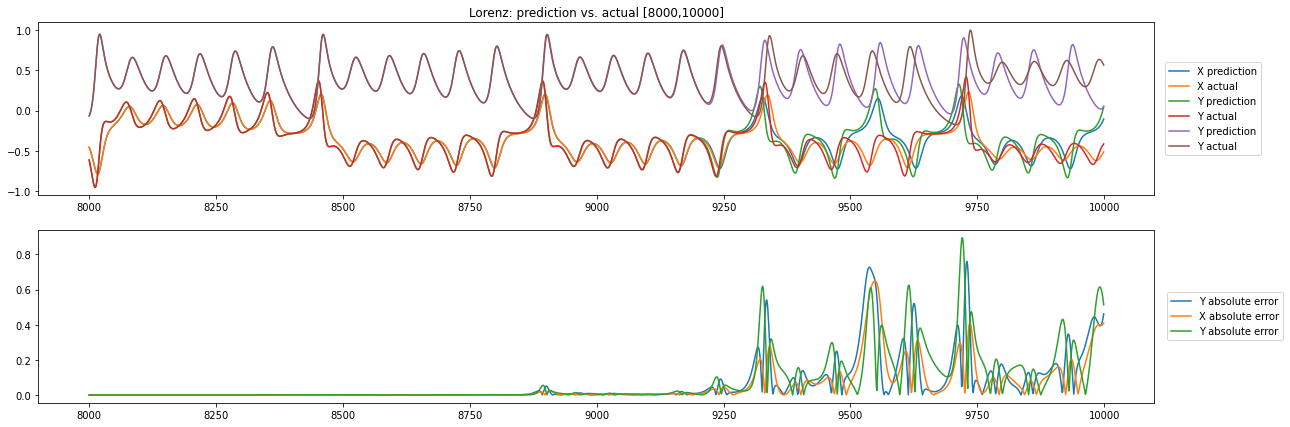

In [16]:
recursive_out = lor_best_recursive_model.recursive_predict(data, train_start, train_end, test_end-test_start)
data_end = train_end
t_forward = test_end-test_start

fig, axs = plt.subplots(2, figsize=(20, 7))
axs[0].plot(np.arange(data_end,data_end+t_forward), recursive_out[:,0], label="X prediction")
axs[0].plot(np.arange(data_end,data_end+t_forward), data[data_end:data_end+t_forward,0], label="X actual")
axs[0].plot(np.arange(data_end,data_end+t_forward), recursive_out[:,1], label="Y prediction")
axs[0].plot(np.arange(data_end,data_end+t_forward), data[data_end:data_end+t_forward,1], label="Y actual")
axs[1].plot(np.arange(data_end,data_end+t_forward), np.abs(recursive_out[:,1]-data[data_end:data_end+t_forward,1]), label="Y absolute error")
axs[1].plot(np.arange(data_end,data_end+t_forward), np.abs(recursive_out[:,0]-data[data_end:data_end+t_forward,0]), label="X absolute error")
axs[0].plot(np.arange(data_end,data_end+t_forward), recursive_out[:,2], label="Y prediction")
axs[0].plot(np.arange(data_end,data_end+t_forward), data[data_end:data_end+t_forward,2], label="Y actual")
axs[1].plot(np.arange(data_end,data_end+t_forward), np.abs(recursive_out[:,2]-data[data_end:data_end+t_forward,2]), label="Y absolute error")
axs[0].legend(loc="right", ncol=1, bbox_to_anchor=(1.1,0.5))
axs[1].legend(loc="right", ncol=1, bbox_to_anchor=(1.12,0.5))
axs[0].set_title(f'Lorenz: prediction vs. actual [{data_end},{data_end+t_forward}]')
plt.subplots_adjust(hspace=0.2)
plt.show()
# fig.savefig(f'./images/lorenz-recursive_k={k}_s={lor_s_star}_reg={lor_reg_star}_[{data_end},{data_end+t_forward}].png',facecolor='white', transparent=False)

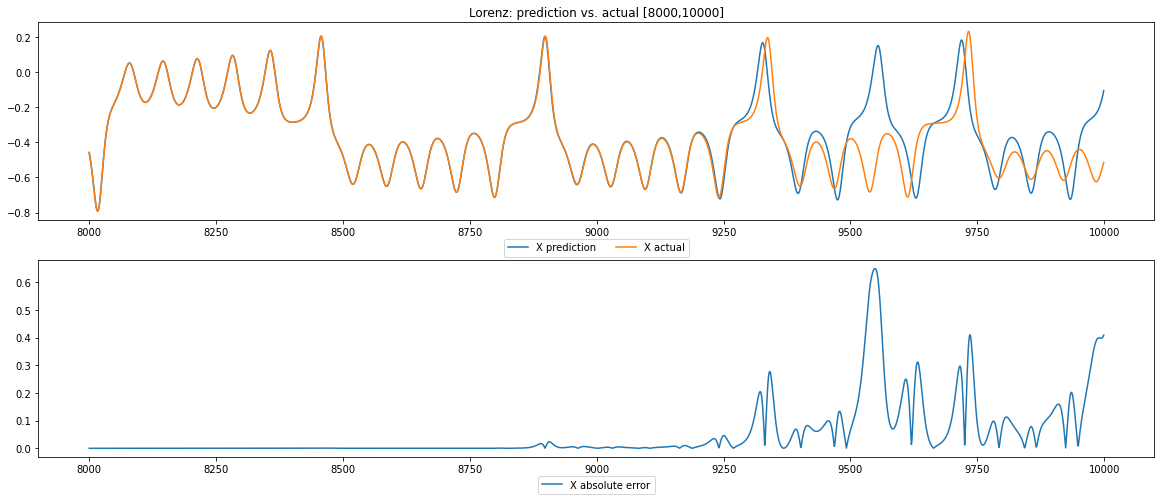

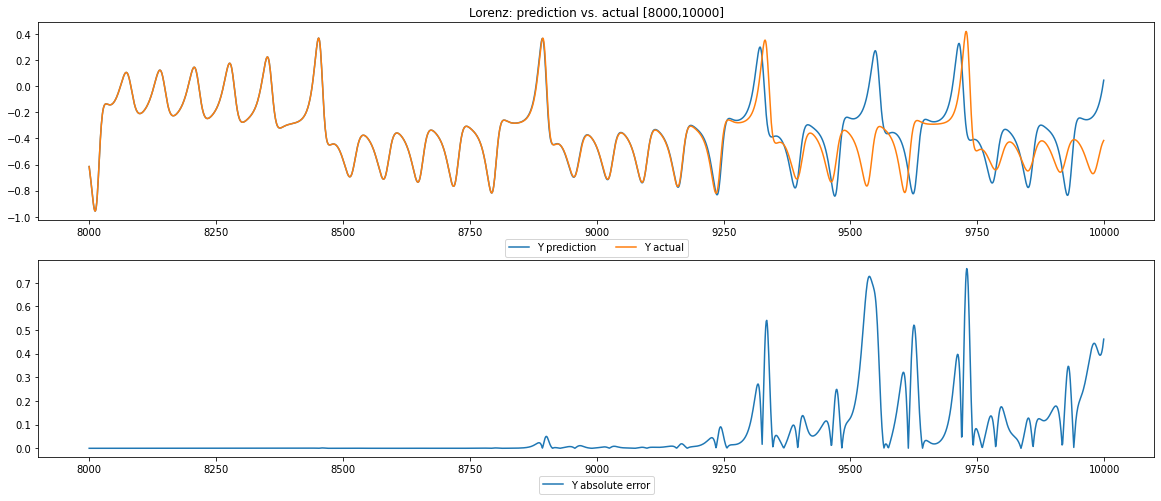

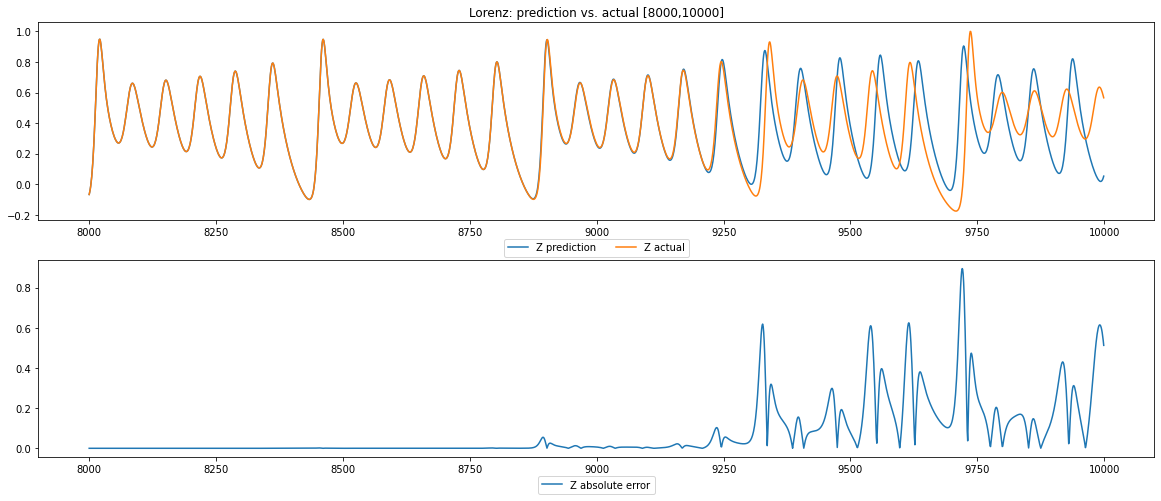

In [17]:
fig, axs = plt.subplots(2, figsize=(20, 8))
axs[0].plot(np.arange(data_end,data_end+t_forward), recursive_out[:,0], label="X prediction")
axs[0].plot(np.arange(data_end,data_end+t_forward), data[data_end:data_end+t_forward,0], label="X actual")
axs[1].plot(np.arange(data_end,data_end+t_forward), np.abs(recursive_out[:,0]-data[data_end:data_end+t_forward,0]), label="X absolute error")
axs[0].legend(loc="lower center", ncol=2, bbox_to_anchor=(0.5,-0.21))
axs[1].legend(loc="lower center", ncol=2, bbox_to_anchor=(0.5,-0.21))
axs[0].set_title(f'Lorenz: prediction vs. actual [{data_end},{data_end+t_forward}]')
plt.show()
# fig.savefig(f'./images/lorenz-recursive-X_k={k}_s={lor_s_star}_reg={lor_reg_star}_[{data_end},{data_end+t_forward}].png',facecolor='white', transparent=False)

fig, axs = plt.subplots(2, figsize=(20, 8))
axs[0].plot(np.arange(data_end,data_end+t_forward), recursive_out[:,1], label="Y prediction")
axs[0].plot(np.arange(data_end,data_end+t_forward), data[data_end:data_end+t_forward,1], label="Y actual")
axs[1].plot(np.arange(data_end,data_end+t_forward), np.abs(recursive_out[:,1]-data[data_end:data_end+t_forward,1]), label="Y absolute error")
axs[0].legend(loc="lower center", ncol=2, bbox_to_anchor=(0.5,-0.21))
axs[1].legend(loc="lower center", ncol=2, bbox_to_anchor=(0.5,-0.21))
axs[0].set_title(f'Lorenz: prediction vs. actual [{data_end},{data_end+t_forward}]')
plt.show()
# fig.savefig(f'./images/lorenz-recursive-Y_k={k}_s={lor_s_star}_reg={lor_reg_star}_[{data_end},{data_end+t_forward}].png',facecolor='white', transparent=False)

fig, axs = plt.subplots(2, figsize=(20, 8))
axs[0].plot(np.arange(data_end,data_end+t_forward), recursive_out[:,2], label="Z prediction")
axs[0].plot(np.arange(data_end,data_end+t_forward), data[data_end:data_end+t_forward,2], label="Z actual")
axs[1].plot(np.arange(data_end,data_end+t_forward), np.abs(recursive_out[:,2]-data[data_end:data_end+t_forward,2]), label="Z absolute error")
axs[0].legend(loc="lower center", ncol=2, bbox_to_anchor=(0.5,-0.21))
axs[1].legend(loc="lower center", ncol=2, bbox_to_anchor=(0.5,-0.21))
axs[0].set_title(f'Lorenz: prediction vs. actual [{data_end},{data_end+t_forward}]')
plt.show()
# fig.savefig(f'./images/lorenz-recursive-Z_k={k}_s={lor_s_star}_reg={lor_reg_star}_[{data_end},{data_end+t_forward}].png',facecolor='white', transparent=False)

In [18]:
RMSE(test_target, recursive_out)

0.2460367217312774

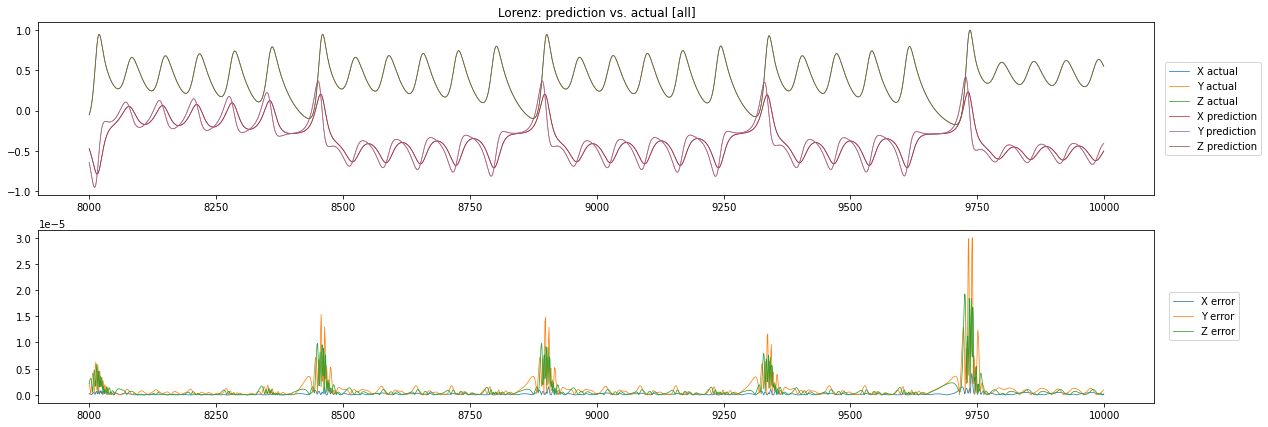

In [19]:
test_out = lor_best_recursive_model.test_out

fig, axs = plt.subplots(2, figsize=(20, 7))
axs[0].plot(np.arange(test_start,test_end), test_target[:,0], linewidth=0.75, label="X actual")
axs[0].plot(np.arange(test_start,test_end), test_target[:,1], linewidth=0.75, label="Y actual")
axs[0].plot(np.arange(test_start,test_end), test_target[:,2], linewidth=0.75, label="Z actual")
axs[0].plot(np.arange(test_start,test_end), test_out[:,0], linewidth=0.75, label="X prediction")
axs[0].plot(np.arange(test_start,test_end), test_out[:,1], linewidth=0.75, label="Y prediction")
axs[0].plot(np.arange(test_start,test_end), test_out[:,2], linewidth=0.75, label="Z prediction")
axs[1].plot(np.arange(test_start,test_end), np.abs(test_out[:,0]-test_target[:,0]), linewidth=0.75, label="X error")
axs[1].plot(np.arange(test_start,test_end), np.abs(test_out[:,1]-test_target[:,1]), linewidth=0.75, label="Y error")
axs[1].plot(np.arange(test_start,test_end), np.abs(test_out[:,2]-test_target[:,2]), linewidth=0.75, label="Z error")
axs[0].legend(loc="right", ncol=1, bbox_to_anchor=(1.1,0.5))
axs[1].legend(loc="right", ncol=1, bbox_to_anchor=(1.08,0.5))
axs[0].set_title('Lorenz: prediction vs. actual [all]')
plt.subplots_adjust(hspace=0.2)
plt.show()
# fig.savefig(f'./images/lorenz-one-step_k={k}_s={lor_s_star}_reg={lor_reg_star}.png',facecolor='white', transparent=False)

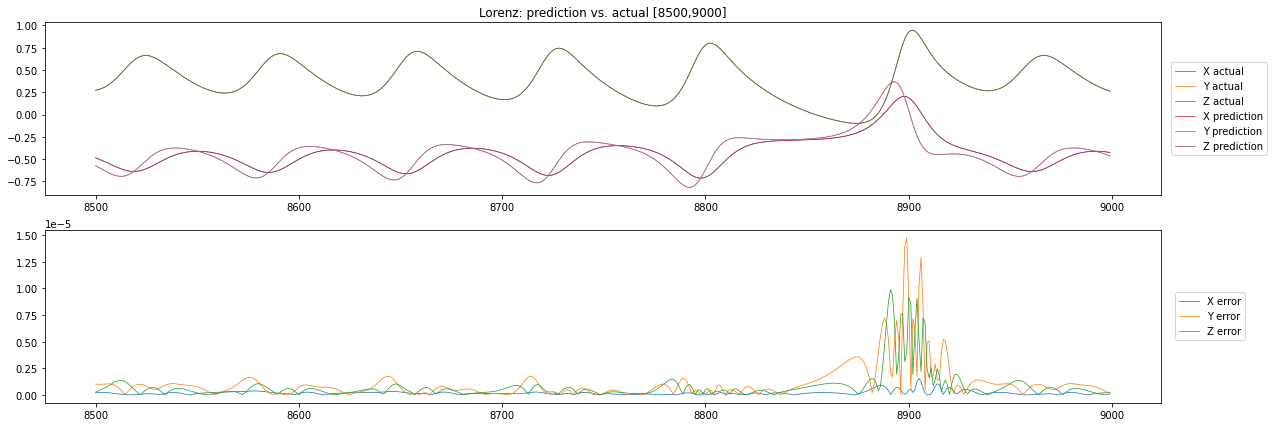

In [20]:
start = 8500
pts_to_show = 500
fig, axs = plt.subplots(2, figsize=(20, 7))
axs[0].plot(np.arange(start,start+pts_to_show), test_target[start-test_start:start-test_start+pts_to_show,0], linewidth=0.75, label="X actual")
axs[0].plot(np.arange(start,start+pts_to_show), test_target[start-test_start:start-test_start+pts_to_show,1], linewidth=0.75, label="Y actual")
axs[0].plot(np.arange(start,start+pts_to_show), test_target[start-test_start:start-test_start+pts_to_show,2], linewidth=0.75, label="Z actual")
axs[0].plot(np.arange(start,start+pts_to_show), test_out[start-test_start:start-test_start+pts_to_show,0], linewidth=0.75, label="X prediction")
axs[0].plot(np.arange(start,start+pts_to_show), test_out[start-test_start:start-test_start+pts_to_show,1], linewidth=0.75, label="Y prediction")
axs[0].plot(np.arange(start,start+pts_to_show), test_out[start-test_start:start-test_start+pts_to_show,2], linewidth=0.75, label="Z prediction")
axs[1].plot(np.arange(start,start+pts_to_show), np.abs(test_out[start-test_start:start-test_start+pts_to_show,0]-test_target[start-test_start:start-test_start+pts_to_show,0]), linewidth=0.75, label="X error")
axs[1].plot(np.arange(start,start+pts_to_show), np.abs(test_out[start-test_start:start-test_start+pts_to_show,1]-test_target[start-test_start:start-test_start+pts_to_show,1]), linewidth=0.75, label="Y error")
axs[1].plot(np.arange(start,start+pts_to_show), np.abs(test_out[start-test_start:start-test_start+pts_to_show,2]-test_target[start-test_start:start-test_start+pts_to_show,2]), linewidth=0.75, label="Z error")
axs[0].legend(loc="right", ncol=1, bbox_to_anchor=(1.1,0.5))
axs[1].legend(loc="right", ncol=1, bbox_to_anchor=(1.08,0.5))
axs[0].set_title(f'Lorenz: prediction vs. actual [{start},{start+pts_to_show}]')
plt.subplots_adjust(hspace=0.2)
plt.show()
# fig.savefig(f'./images/lorenz-one-step_k={k}_s={lor_s_star}_reg={lor_reg_star}_[{start},{start+pts_to_show}].png',facecolor='white', transparent=False)

In [21]:
# RMSE(test_out, test_target), lor_rmse_arr[lor_min_rmse_index]
RMSE(test_out, test_target)

3.144323174920089e-06

Examining Gaussian Noise

(array([  2.,   5.,  49., 127., 257., 274., 183.,  84.,  18.,   1.]),
 array([-0.38122792, -0.30828137, -0.23533482, -0.16238827, -0.08944172, -0.01649517,  0.05645138,  0.12939793,  0.20234448,  0.27529103,  0.34823758]),
 <BarContainer object of 10 artists>)

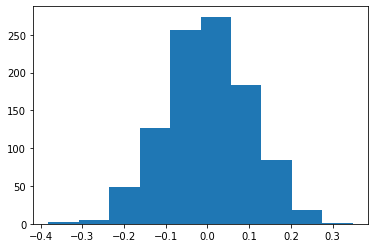

In [36]:
plt.hist(np.random.normal(scale=0.1, size=1000))

In [37]:
mu_arr = [0, 1e-10, 1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2]

noisy_data_arr = []
for i in range(len(mu_arr)):
    noisy_data_arr.append(data + np.random.normal(scale=mu_arr[i], size=data.shape))

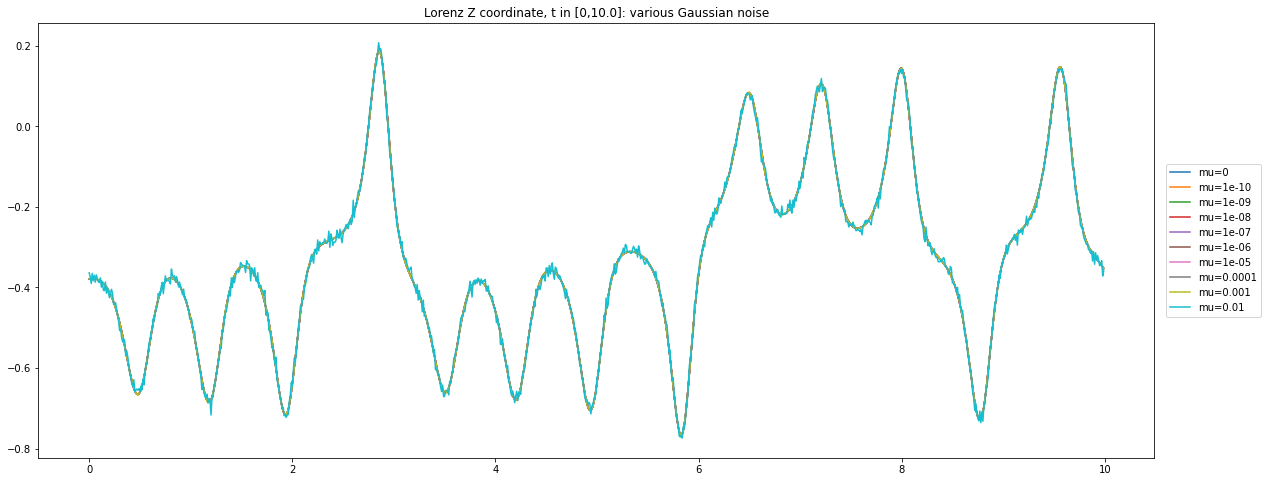

In [38]:
num_pts = 1000

fig, axs = plt.subplots(1, figsize=(20, 8))
# axs.plot(lorenz_scaled[:num_pts,0], data[:num_pts,0], label="raw")
for i in range(len(mu_arr)):
    axs.plot(lorenz_scaled[:num_pts,0], noisy_data_arr[i][:num_pts,0], label=f'mu={mu_arr[i]}')
axs.legend(loc="right", ncol=1, bbox_to_anchor=(1.1,0.5))
axs.set_title(f'Lorenz Z coordinate, t in [0,{lorenz_scaled[num_pts,0]}]: various Gaussian noise')
plt.show()

In [39]:
k_arr = [
    # k, model size
    4, #91
    6, #190
    8, #325
    9, #406
    10, #496
    11, #595
    12, #703
    13, #820
    14, #946
]

s_grid = [1,2,3,4,5,6,7,8,10,15,20,25,30]
reg_grid = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]

best_model_arr = []
best_s_arr = []
best_reg_arr = []
best_rmse_arr = []

for k in k_arr:
    print(f'starting: k={k}')
    lor_model_arr = []
    lor_recursive_rmse_arr = []
    for s in s_grid:
        for r in reg_grid:
            model = NVARModel(k, s, r)
            model.train(data, target, train_indices)
            lor_recursive_rmse_arr.append(RMSE(test_target,model.recursive_predict(data, train_start, train_end, test_end-test_start)))
            lor_model_arr.append(model)
    lor_recursive_rmse_arr = np.array(lor_recursive_rmse_arr)
    lor_best_recursive_idx = np.argmin(lor_recursive_rmse_arr[~np.isnan(lor_recursive_rmse_arr)])
    lor_best_recursive_model = [lor_model_arr[i] for i in range(len(lor_model_arr)) if ~np.isnan(lor_recursive_rmse_arr)[i]][lor_best_recursive_idx]
    best_model_arr.append(lor_best_recursive_model)
    best_s_arr.append(lor_best_recursive_model.s)
    best_reg_arr.append(lor_best_recursive_model.reg)
    best_rmse_arr.append(RMSE(test_target,lor_best_recursive_model.recursive_predict(data, train_start, train_end, test_end-test_start)))
    print(f'    best s   : {lor_best_recursive_model.s}')
    print(f'    best reg : {lor_best_recursive_model.reg}')
    print(f'    best rmse: {best_rmse_arr[-1]}')

starting: k=4


/Users/samuelhocking/Files/Research/math/SciML/Code/chaotic-ml/NVAR.py:13: RuntimeWarning: overflow encountered in multiply
  [lin[i]*lin[i:,:] for i in range(len(lin))]
/Users/samuelhocking/Files/Research/math/SciML/Code/chaotic-ml/NVAR.py:51: RuntimeWarning: invalid value encountered in matmul
  y = state_vect.T @ self.w


    best s   : 4
    best reg : 1e-06
    best rmse: 0.2460367217312774
starting: k=6
    best s   : 3
    best reg : 1e-07
    best rmse: 0.2505528703734938
starting: k=8
    best s   : 2
    best reg : 1e-07
    best rmse: 0.2305980306183608
starting: k=9
    best s   : 2
    best reg : 1e-06
    best rmse: 0.23002549707838577
starting: k=10
    best s   : 1
    best reg : 1e-06
    best rmse: 0.26723394873717915
starting: k=11
    best s   : 3
    best reg : 1e-07
    best rmse: 0.262198247552501
starting: k=12
    best s   : 1
    best reg : 1e-07
    best rmse: 0.3036716630781259
starting: k=13
    best s   : 1
    best reg : 1e-07
    best rmse: 0.26809771985248343
starting: k=14
    best s   : 1
    best reg : 1e-07
    best rmse: 0.22778853449223688


k = 4
mu = 0
RMSE = 0.2460367217312774


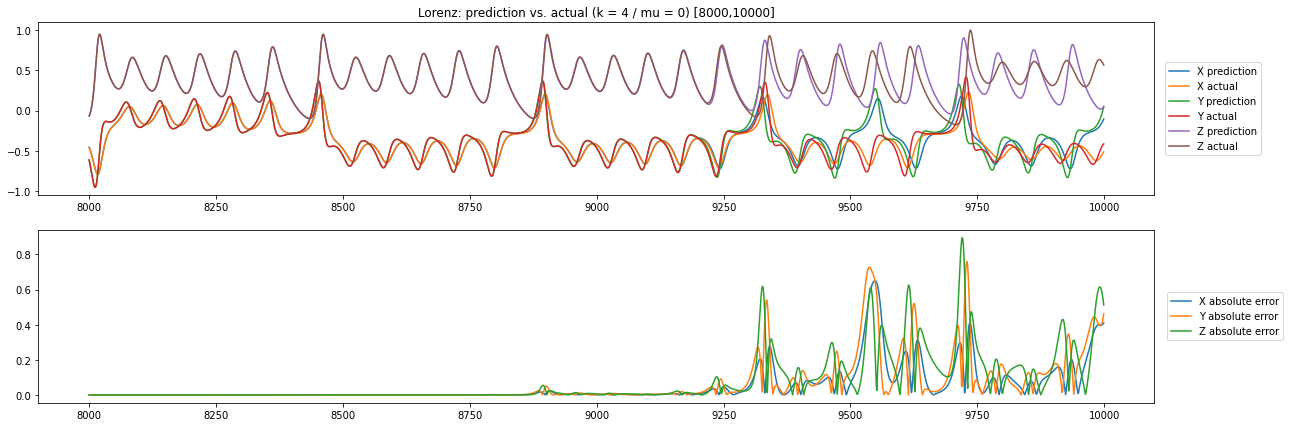

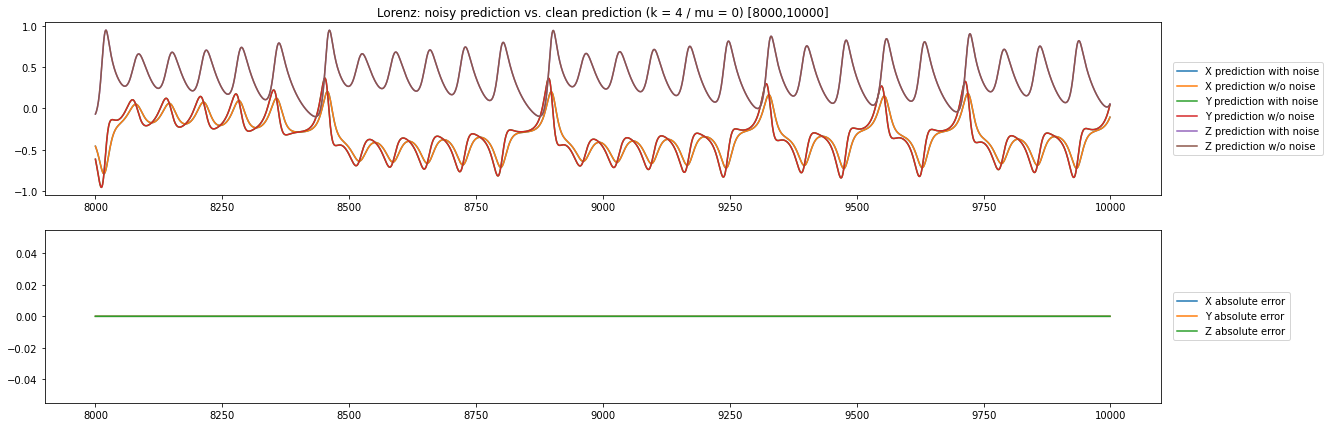

In [40]:
model_idx = 0
print(f'k = {best_model_arr[model_idx].k}')

noise_idx = 0
print(f'mu = {mu_arr[noise_idx]}')

model = best_model_arr[model_idx]
model.train(noisy_data_arr[noise_idx], target, train_indices)
recursive_out = model.recursive_predict(noisy_data_arr[noise_idx], train_start, train_end, test_end-test_start)

clean_model = best_model_arr[model_idx]
clean_model.train(noisy_data_arr[0], target, train_indices)
clean_recursive_out = clean_model.recursive_predict(noisy_data_arr[0], train_start, train_end, test_end-test_start)

print(f'RMSE = {RMSE(test_target, recursive_out)}')

data_end = train_end
t_forward = test_end-test_start

fig, axs = plt.subplots(2, figsize=(20, 7))
axs[0].plot(np.arange(data_end,data_end+t_forward), recursive_out[:,0], label="X prediction")
axs[0].plot(np.arange(data_end,data_end+t_forward), data[data_end:data_end+t_forward,0], label="X actual")
axs[0].plot(np.arange(data_end,data_end+t_forward), recursive_out[:,1], label="Y prediction")
axs[0].plot(np.arange(data_end,data_end+t_forward), data[data_end:data_end+t_forward,1], label="Y actual")
axs[0].plot(np.arange(data_end,data_end+t_forward), recursive_out[:,2], label="Z prediction")
axs[0].plot(np.arange(data_end,data_end+t_forward), data[data_end:data_end+t_forward,2], label="Z actual")
axs[1].plot(np.arange(data_end,data_end+t_forward), np.abs(recursive_out[:,0]-data[data_end:data_end+t_forward,0]), label="X absolute error")
axs[1].plot(np.arange(data_end,data_end+t_forward), np.abs(recursive_out[:,1]-data[data_end:data_end+t_forward,1]), label="Y absolute error")
axs[1].plot(np.arange(data_end,data_end+t_forward), np.abs(recursive_out[:,2]-data[data_end:data_end+t_forward,2]), label="Z absolute error")
axs[0].legend(loc="right", ncol=1, bbox_to_anchor=(1.1,0.5))
axs[1].legend(loc="right", ncol=1, bbox_to_anchor=(1.12,0.5))
axs[0].set_title(f'Lorenz: prediction vs. actual (k = {best_model_arr[model_idx].k} / mu = {mu_arr[noise_idx]}) [{data_end},{data_end+t_forward}]')
plt.subplots_adjust(hspace=0.2)
plt.show()
# fig.savefig(f'./images/lorenz-recursive_k={k}_s={lor_s_star}_reg={lor_reg_star}_[{data_end},{data_end+t_forward}].png',facecolor='white', transparent=False)

fig, axs = plt.subplots(2, figsize=(20, 7))
axs[0].plot(np.arange(data_end,data_end+t_forward), recursive_out[:,0], label="X prediction with noise")
axs[0].plot(np.arange(data_end,data_end+t_forward), clean_recursive_out[:,0], label="X prediction w/o noise")
axs[0].plot(np.arange(data_end,data_end+t_forward), recursive_out[:,1], label="Y prediction with noise")
axs[0].plot(np.arange(data_end,data_end+t_forward), clean_recursive_out[:,1], label="Y prediction w/o noise")
axs[0].plot(np.arange(data_end,data_end+t_forward), recursive_out[:,2], label="Z prediction with noise")
axs[0].plot(np.arange(data_end,data_end+t_forward), clean_recursive_out[:,2], label="Z prediction w/o noise")

axs[1].plot(np.arange(data_end,data_end+t_forward), np.abs(recursive_out[:,0]-clean_recursive_out[:,0]), label="X absolute error")
axs[1].plot(np.arange(data_end,data_end+t_forward), np.abs(recursive_out[:,1]-clean_recursive_out[:,1]), label="Y absolute error")
axs[1].plot(np.arange(data_end,data_end+t_forward), np.abs(recursive_out[:,2]-clean_recursive_out[:,2]), label="Z absolute error")
axs[0].legend(loc="right", ncol=1, bbox_to_anchor=(1.15,0.5))
axs[1].legend(loc="right", ncol=1, bbox_to_anchor=(1.12,0.5))
axs[0].set_title(f'Lorenz: noisy prediction vs. clean prediction (k = {best_model_arr[model_idx].k} / mu = {mu_arr[noise_idx]}) [{data_end},{data_end+t_forward}]')
plt.subplots_adjust(hspace=0.2)
plt.show()

k = 4
mu = 1e-10
RMSE = 0.24572312215656747


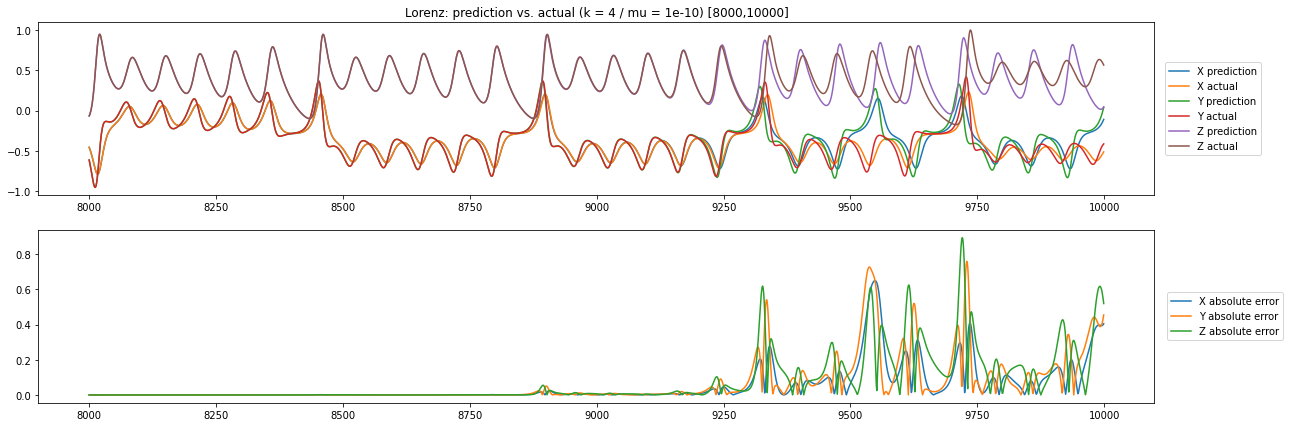

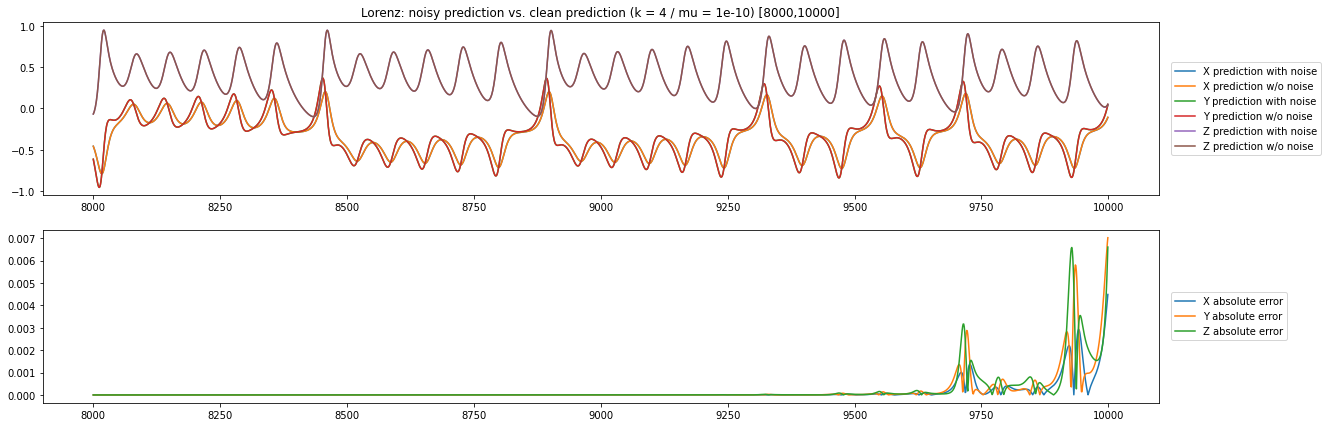

In [41]:
model_idx = 0
print(f'k = {best_model_arr[model_idx].k}')

noise_idx = 1
print(f'mu = {mu_arr[noise_idx]}')

model = best_model_arr[model_idx]
model.train(noisy_data_arr[noise_idx], target, train_indices)
recursive_out = model.recursive_predict(noisy_data_arr[noise_idx], train_start, train_end, test_end-test_start)

clean_model = best_model_arr[model_idx]
clean_model.train(noisy_data_arr[0], target, train_indices)
clean_recursive_out = clean_model.recursive_predict(noisy_data_arr[0], train_start, train_end, test_end-test_start)

print(f'RMSE = {RMSE(test_target, recursive_out)}')

data_end = train_end
t_forward = test_end-test_start

fig, axs = plt.subplots(2, figsize=(20, 7))
axs[0].plot(np.arange(data_end,data_end+t_forward), recursive_out[:,0], label="X prediction")
axs[0].plot(np.arange(data_end,data_end+t_forward), data[data_end:data_end+t_forward,0], label="X actual")
axs[0].plot(np.arange(data_end,data_end+t_forward), recursive_out[:,1], label="Y prediction")
axs[0].plot(np.arange(data_end,data_end+t_forward), data[data_end:data_end+t_forward,1], label="Y actual")
axs[0].plot(np.arange(data_end,data_end+t_forward), recursive_out[:,2], label="Z prediction")
axs[0].plot(np.arange(data_end,data_end+t_forward), data[data_end:data_end+t_forward,2], label="Z actual")
axs[1].plot(np.arange(data_end,data_end+t_forward), np.abs(recursive_out[:,0]-data[data_end:data_end+t_forward,0]), label="X absolute error")
axs[1].plot(np.arange(data_end,data_end+t_forward), np.abs(recursive_out[:,1]-data[data_end:data_end+t_forward,1]), label="Y absolute error")
axs[1].plot(np.arange(data_end,data_end+t_forward), np.abs(recursive_out[:,2]-data[data_end:data_end+t_forward,2]), label="Z absolute error")
axs[0].legend(loc="right", ncol=1, bbox_to_anchor=(1.1,0.5))
axs[1].legend(loc="right", ncol=1, bbox_to_anchor=(1.12,0.5))
axs[0].set_title(f'Lorenz: prediction vs. actual (k = {best_model_arr[model_idx].k} / mu = {mu_arr[noise_idx]}) [{data_end},{data_end+t_forward}]')
plt.subplots_adjust(hspace=0.2)
plt.show()
# fig.savefig(f'./images/lorenz-recursive_k={k}_s={lor_s_star}_reg={lor_reg_star}_[{data_end},{data_end+t_forward}].png',facecolor='white', transparent=False)

fig, axs = plt.subplots(2, figsize=(20, 7))
axs[0].plot(np.arange(data_end,data_end+t_forward), recursive_out[:,0], label="X prediction with noise")
axs[0].plot(np.arange(data_end,data_end+t_forward), clean_recursive_out[:,0], label="X prediction w/o noise")
axs[0].plot(np.arange(data_end,data_end+t_forward), recursive_out[:,1], label="Y prediction with noise")
axs[0].plot(np.arange(data_end,data_end+t_forward), clean_recursive_out[:,1], label="Y prediction w/o noise")
axs[0].plot(np.arange(data_end,data_end+t_forward), recursive_out[:,2], label="Z prediction with noise")
axs[0].plot(np.arange(data_end,data_end+t_forward), clean_recursive_out[:,2], label="Z prediction w/o noise")

axs[1].plot(np.arange(data_end,data_end+t_forward), np.abs(recursive_out[:,0]-clean_recursive_out[:,0]), label="X absolute error")
axs[1].plot(np.arange(data_end,data_end+t_forward), np.abs(recursive_out[:,1]-clean_recursive_out[:,1]), label="Y absolute error")
axs[1].plot(np.arange(data_end,data_end+t_forward), np.abs(recursive_out[:,2]-clean_recursive_out[:,2]), label="Z absolute error")
axs[0].legend(loc="right", ncol=1, bbox_to_anchor=(1.15,0.5))
axs[1].legend(loc="right", ncol=1, bbox_to_anchor=(1.12,0.5))
axs[0].set_title(f'Lorenz: noisy prediction vs. clean prediction (k = {best_model_arr[model_idx].k} / mu = {mu_arr[noise_idx]}) [{data_end},{data_end+t_forward}]')
plt.subplots_adjust(hspace=0.2)
plt.show()

k = 4
mu = 1e-09
RMSE = 0.2442312136731474


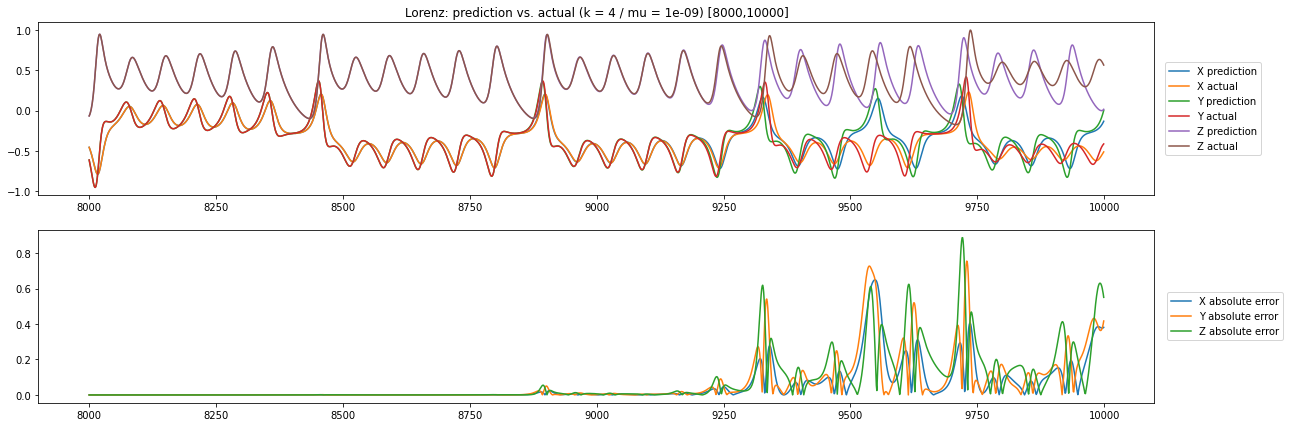

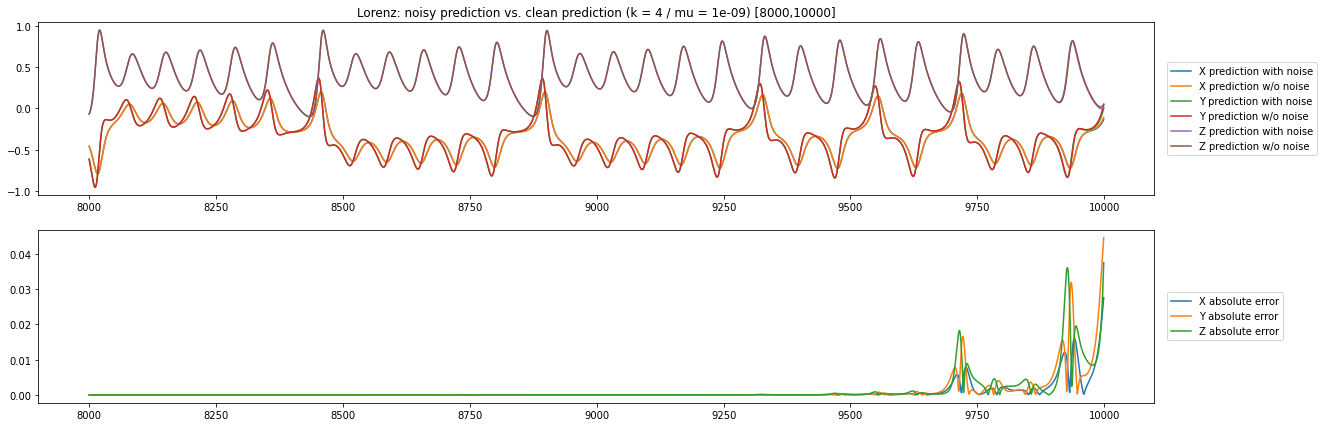

In [42]:
model_idx = 0
print(f'k = {best_model_arr[model_idx].k}')

noise_idx = 2
print(f'mu = {mu_arr[noise_idx]}')

model = best_model_arr[model_idx]
model.train(noisy_data_arr[noise_idx], target, train_indices)
recursive_out = model.recursive_predict(noisy_data_arr[noise_idx], train_start, train_end, test_end-test_start)

clean_model = best_model_arr[model_idx]
clean_model.train(noisy_data_arr[0], target, train_indices)
clean_recursive_out = clean_model.recursive_predict(noisy_data_arr[0], train_start, train_end, test_end-test_start)

print(f'RMSE = {RMSE(test_target, recursive_out)}')

data_end = train_end
t_forward = test_end-test_start

fig, axs = plt.subplots(2, figsize=(20, 7))
axs[0].plot(np.arange(data_end,data_end+t_forward), recursive_out[:,0], label="X prediction")
axs[0].plot(np.arange(data_end,data_end+t_forward), data[data_end:data_end+t_forward,0], label="X actual")
axs[0].plot(np.arange(data_end,data_end+t_forward), recursive_out[:,1], label="Y prediction")
axs[0].plot(np.arange(data_end,data_end+t_forward), data[data_end:data_end+t_forward,1], label="Y actual")
axs[0].plot(np.arange(data_end,data_end+t_forward), recursive_out[:,2], label="Z prediction")
axs[0].plot(np.arange(data_end,data_end+t_forward), data[data_end:data_end+t_forward,2], label="Z actual")
axs[1].plot(np.arange(data_end,data_end+t_forward), np.abs(recursive_out[:,0]-data[data_end:data_end+t_forward,0]), label="X absolute error")
axs[1].plot(np.arange(data_end,data_end+t_forward), np.abs(recursive_out[:,1]-data[data_end:data_end+t_forward,1]), label="Y absolute error")
axs[1].plot(np.arange(data_end,data_end+t_forward), np.abs(recursive_out[:,2]-data[data_end:data_end+t_forward,2]), label="Z absolute error")
axs[0].legend(loc="right", ncol=1, bbox_to_anchor=(1.1,0.5))
axs[1].legend(loc="right", ncol=1, bbox_to_anchor=(1.12,0.5))
axs[0].set_title(f'Lorenz: prediction vs. actual (k = {best_model_arr[model_idx].k} / mu = {mu_arr[noise_idx]}) [{data_end},{data_end+t_forward}]')
plt.subplots_adjust(hspace=0.2)
plt.show()
# fig.savefig(f'./images/lorenz-recursive_k={k}_s={lor_s_star}_reg={lor_reg_star}_[{data_end},{data_end+t_forward}].png',facecolor='white', transparent=False)

fig, axs = plt.subplots(2, figsize=(20, 7))
axs[0].plot(np.arange(data_end,data_end+t_forward), recursive_out[:,0], label="X prediction with noise")
axs[0].plot(np.arange(data_end,data_end+t_forward), clean_recursive_out[:,0], label="X prediction w/o noise")
axs[0].plot(np.arange(data_end,data_end+t_forward), recursive_out[:,1], label="Y prediction with noise")
axs[0].plot(np.arange(data_end,data_end+t_forward), clean_recursive_out[:,1], label="Y prediction w/o noise")
axs[0].plot(np.arange(data_end,data_end+t_forward), recursive_out[:,2], label="Z prediction with noise")
axs[0].plot(np.arange(data_end,data_end+t_forward), clean_recursive_out[:,2], label="Z prediction w/o noise")

axs[1].plot(np.arange(data_end,data_end+t_forward), np.abs(recursive_out[:,0]-clean_recursive_out[:,0]), label="X absolute error")
axs[1].plot(np.arange(data_end,data_end+t_forward), np.abs(recursive_out[:,1]-clean_recursive_out[:,1]), label="Y absolute error")
axs[1].plot(np.arange(data_end,data_end+t_forward), np.abs(recursive_out[:,2]-clean_recursive_out[:,2]), label="Z absolute error")
axs[0].legend(loc="right", ncol=1, bbox_to_anchor=(1.15,0.5))
axs[1].legend(loc="right", ncol=1, bbox_to_anchor=(1.12,0.5))
axs[0].set_title(f'Lorenz: noisy prediction vs. clean prediction (k = {best_model_arr[model_idx].k} / mu = {mu_arr[noise_idx]}) [{data_end},{data_end+t_forward}]')
plt.subplots_adjust(hspace=0.2)
plt.show()

k = 4
mu = 1e-08
RMSE = 0.24271720164547406


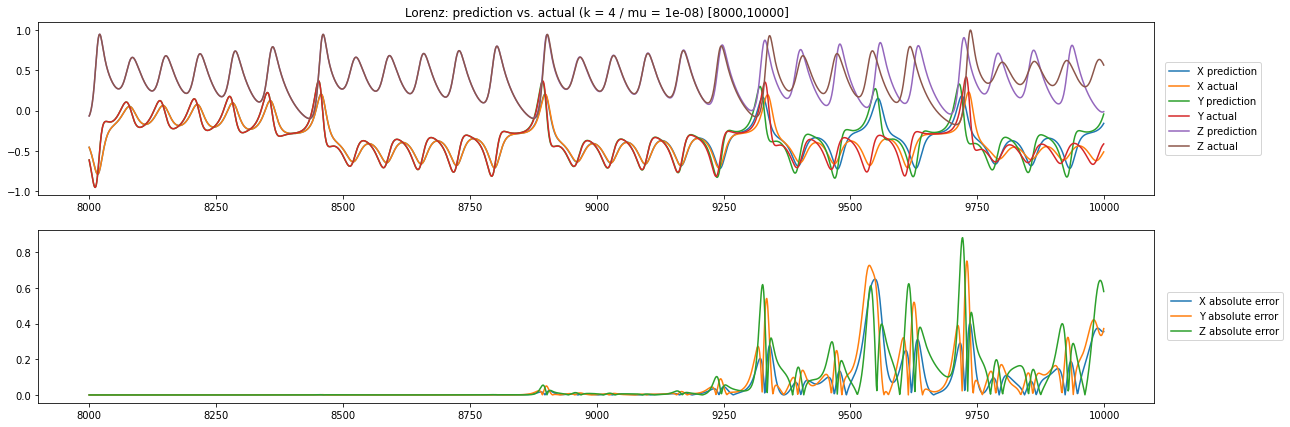

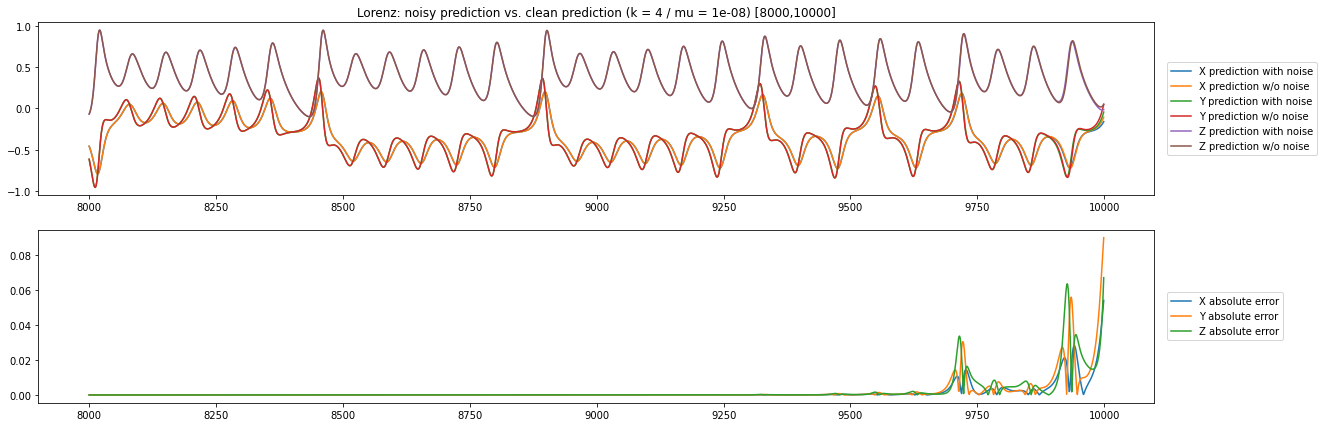

In [43]:
model_idx = 0
print(f'k = {best_model_arr[model_idx].k}')

noise_idx = 3
print(f'mu = {mu_arr[noise_idx]}')

model = best_model_arr[model_idx]
model.train(noisy_data_arr[noise_idx], target, train_indices)
recursive_out = model.recursive_predict(noisy_data_arr[noise_idx], train_start, train_end, test_end-test_start)

clean_model = best_model_arr[model_idx]
clean_model.train(noisy_data_arr[0], target, train_indices)
clean_recursive_out = clean_model.recursive_predict(noisy_data_arr[0], train_start, train_end, test_end-test_start)

print(f'RMSE = {RMSE(test_target, recursive_out)}')

data_end = train_end
t_forward = test_end-test_start

fig, axs = plt.subplots(2, figsize=(20, 7))
axs[0].plot(np.arange(data_end,data_end+t_forward), recursive_out[:,0], label="X prediction")
axs[0].plot(np.arange(data_end,data_end+t_forward), data[data_end:data_end+t_forward,0], label="X actual")
axs[0].plot(np.arange(data_end,data_end+t_forward), recursive_out[:,1], label="Y prediction")
axs[0].plot(np.arange(data_end,data_end+t_forward), data[data_end:data_end+t_forward,1], label="Y actual")
axs[0].plot(np.arange(data_end,data_end+t_forward), recursive_out[:,2], label="Z prediction")
axs[0].plot(np.arange(data_end,data_end+t_forward), data[data_end:data_end+t_forward,2], label="Z actual")
axs[1].plot(np.arange(data_end,data_end+t_forward), np.abs(recursive_out[:,0]-data[data_end:data_end+t_forward,0]), label="X absolute error")
axs[1].plot(np.arange(data_end,data_end+t_forward), np.abs(recursive_out[:,1]-data[data_end:data_end+t_forward,1]), label="Y absolute error")
axs[1].plot(np.arange(data_end,data_end+t_forward), np.abs(recursive_out[:,2]-data[data_end:data_end+t_forward,2]), label="Z absolute error")
axs[0].legend(loc="right", ncol=1, bbox_to_anchor=(1.1,0.5))
axs[1].legend(loc="right", ncol=1, bbox_to_anchor=(1.12,0.5))
axs[0].set_title(f'Lorenz: prediction vs. actual (k = {best_model_arr[model_idx].k} / mu = {mu_arr[noise_idx]}) [{data_end},{data_end+t_forward}]')
plt.subplots_adjust(hspace=0.2)
plt.show()
# fig.savefig(f'./images/lorenz-recursive_k={k}_s={lor_s_star}_reg={lor_reg_star}_[{data_end},{data_end+t_forward}].png',facecolor='white', transparent=False)

fig, axs = plt.subplots(2, figsize=(20, 7))
axs[0].plot(np.arange(data_end,data_end+t_forward), recursive_out[:,0], label="X prediction with noise")
axs[0].plot(np.arange(data_end,data_end+t_forward), clean_recursive_out[:,0], label="X prediction w/o noise")
axs[0].plot(np.arange(data_end,data_end+t_forward), recursive_out[:,1], label="Y prediction with noise")
axs[0].plot(np.arange(data_end,data_end+t_forward), clean_recursive_out[:,1], label="Y prediction w/o noise")
axs[0].plot(np.arange(data_end,data_end+t_forward), recursive_out[:,2], label="Z prediction with noise")
axs[0].plot(np.arange(data_end,data_end+t_forward), clean_recursive_out[:,2], label="Z prediction w/o noise")

axs[1].plot(np.arange(data_end,data_end+t_forward), np.abs(recursive_out[:,0]-clean_recursive_out[:,0]), label="X absolute error")
axs[1].plot(np.arange(data_end,data_end+t_forward), np.abs(recursive_out[:,1]-clean_recursive_out[:,1]), label="Y absolute error")
axs[1].plot(np.arange(data_end,data_end+t_forward), np.abs(recursive_out[:,2]-clean_recursive_out[:,2]), label="Z absolute error")
axs[0].legend(loc="right", ncol=1, bbox_to_anchor=(1.15,0.5))
axs[1].legend(loc="right", ncol=1, bbox_to_anchor=(1.12,0.5))
axs[0].set_title(f'Lorenz: noisy prediction vs. clean prediction (k = {best_model_arr[model_idx].k} / mu = {mu_arr[noise_idx]}) [{data_end},{data_end+t_forward}]')
plt.subplots_adjust(hspace=0.2)
plt.show()

k = 4
mu = 1e-07
RMSE = 0.2922957971540719


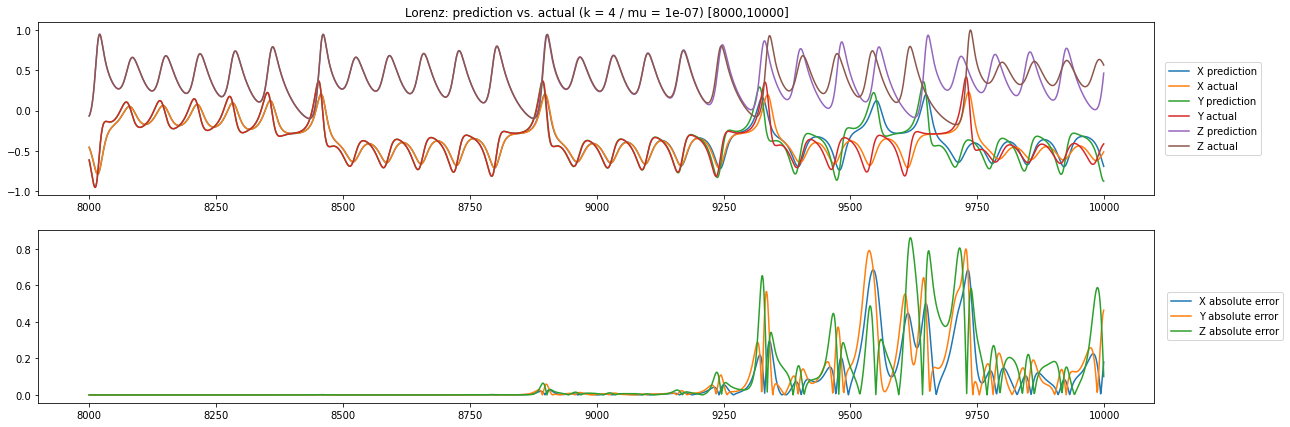

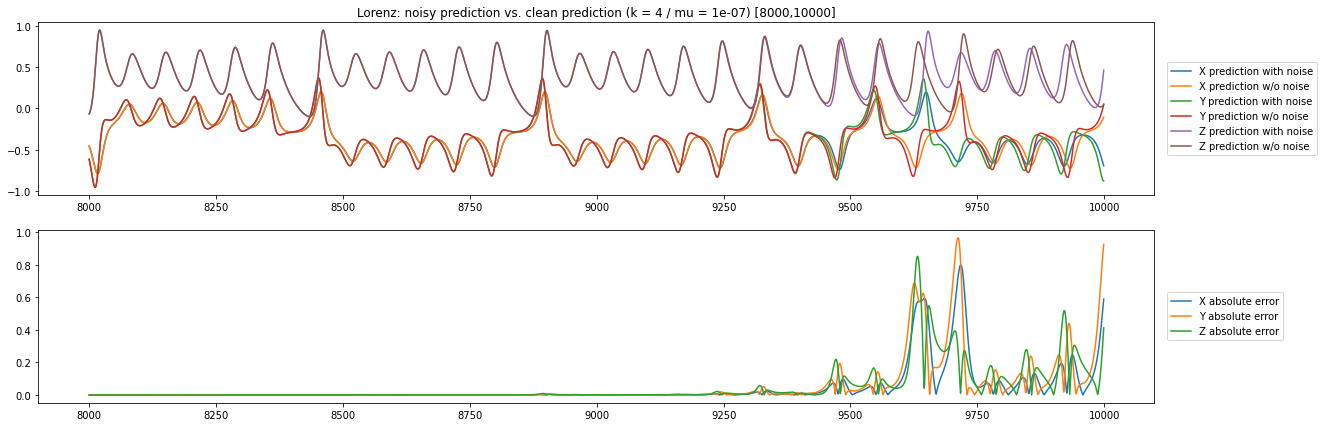

In [44]:
model_idx = 0
print(f'k = {best_model_arr[model_idx].k}')

noise_idx = 4
print(f'mu = {mu_arr[noise_idx]}')

model = best_model_arr[model_idx]
model.train(noisy_data_arr[noise_idx], target, train_indices)
recursive_out = model.recursive_predict(noisy_data_arr[noise_idx], train_start, train_end, test_end-test_start)

clean_model = best_model_arr[model_idx]
clean_model.train(noisy_data_arr[0], target, train_indices)
clean_recursive_out = clean_model.recursive_predict(noisy_data_arr[0], train_start, train_end, test_end-test_start)

print(f'RMSE = {RMSE(test_target, recursive_out)}')

data_end = train_end
t_forward = test_end-test_start

fig, axs = plt.subplots(2, figsize=(20, 7))
axs[0].plot(np.arange(data_end,data_end+t_forward), recursive_out[:,0], label="X prediction")
axs[0].plot(np.arange(data_end,data_end+t_forward), data[data_end:data_end+t_forward,0], label="X actual")
axs[0].plot(np.arange(data_end,data_end+t_forward), recursive_out[:,1], label="Y prediction")
axs[0].plot(np.arange(data_end,data_end+t_forward), data[data_end:data_end+t_forward,1], label="Y actual")
axs[0].plot(np.arange(data_end,data_end+t_forward), recursive_out[:,2], label="Z prediction")
axs[0].plot(np.arange(data_end,data_end+t_forward), data[data_end:data_end+t_forward,2], label="Z actual")
axs[1].plot(np.arange(data_end,data_end+t_forward), np.abs(recursive_out[:,0]-data[data_end:data_end+t_forward,0]), label="X absolute error")
axs[1].plot(np.arange(data_end,data_end+t_forward), np.abs(recursive_out[:,1]-data[data_end:data_end+t_forward,1]), label="Y absolute error")
axs[1].plot(np.arange(data_end,data_end+t_forward), np.abs(recursive_out[:,2]-data[data_end:data_end+t_forward,2]), label="Z absolute error")
axs[0].legend(loc="right", ncol=1, bbox_to_anchor=(1.1,0.5))
axs[1].legend(loc="right", ncol=1, bbox_to_anchor=(1.12,0.5))
axs[0].set_title(f'Lorenz: prediction vs. actual (k = {best_model_arr[model_idx].k} / mu = {mu_arr[noise_idx]}) [{data_end},{data_end+t_forward}]')
plt.subplots_adjust(hspace=0.2)
plt.show()
# fig.savefig(f'./images/lorenz-recursive_k={k}_s={lor_s_star}_reg={lor_reg_star}_[{data_end},{data_end+t_forward}].png',facecolor='white', transparent=False)

fig, axs = plt.subplots(2, figsize=(20, 7))
axs[0].plot(np.arange(data_end,data_end+t_forward), recursive_out[:,0], label="X prediction with noise")
axs[0].plot(np.arange(data_end,data_end+t_forward), clean_recursive_out[:,0], label="X prediction w/o noise")
axs[0].plot(np.arange(data_end,data_end+t_forward), recursive_out[:,1], label="Y prediction with noise")
axs[0].plot(np.arange(data_end,data_end+t_forward), clean_recursive_out[:,1], label="Y prediction w/o noise")
axs[0].plot(np.arange(data_end,data_end+t_forward), recursive_out[:,2], label="Z prediction with noise")
axs[0].plot(np.arange(data_end,data_end+t_forward), clean_recursive_out[:,2], label="Z prediction w/o noise")

axs[1].plot(np.arange(data_end,data_end+t_forward), np.abs(recursive_out[:,0]-clean_recursive_out[:,0]), label="X absolute error")
axs[1].plot(np.arange(data_end,data_end+t_forward), np.abs(recursive_out[:,1]-clean_recursive_out[:,1]), label="Y absolute error")
axs[1].plot(np.arange(data_end,data_end+t_forward), np.abs(recursive_out[:,2]-clean_recursive_out[:,2]), label="Z absolute error")
axs[0].legend(loc="right", ncol=1, bbox_to_anchor=(1.15,0.5))
axs[1].legend(loc="right", ncol=1, bbox_to_anchor=(1.12,0.5))
axs[0].set_title(f'Lorenz: noisy prediction vs. clean prediction (k = {best_model_arr[model_idx].k} / mu = {mu_arr[noise_idx]}) [{data_end},{data_end+t_forward}]')
plt.subplots_adjust(hspace=0.2)
plt.show()

k = 4
mu = 1e-06
RMSE = 0.2559572448525281


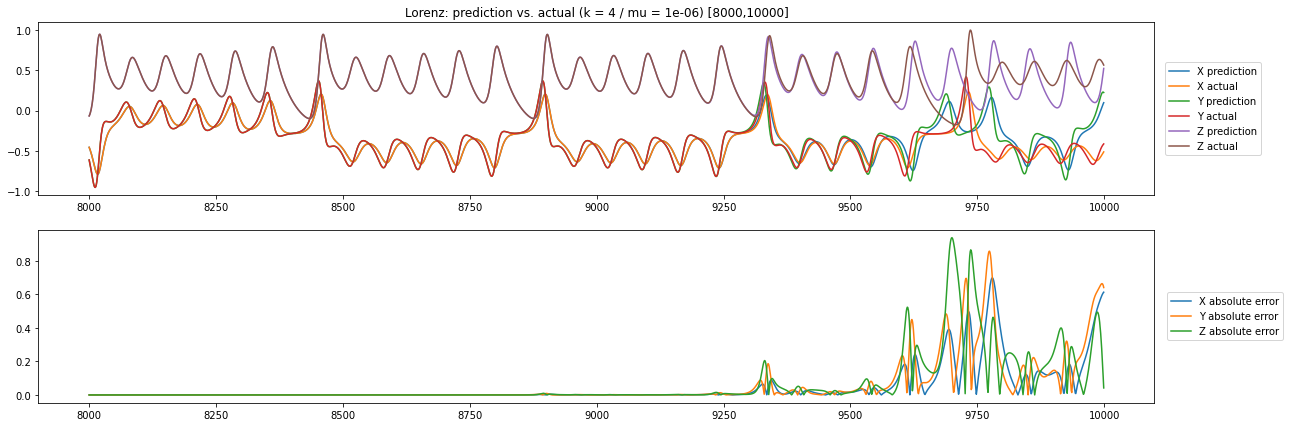

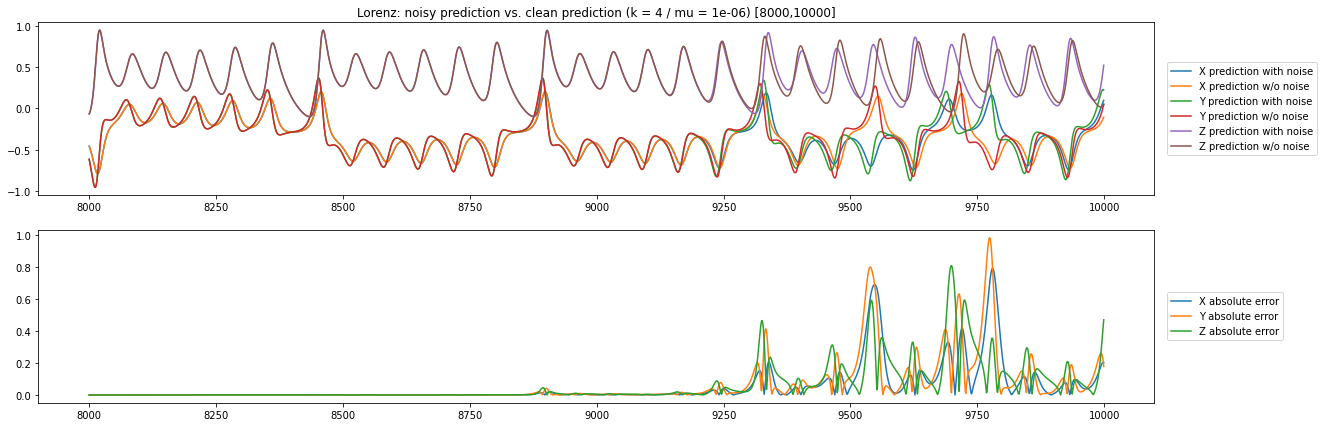

In [45]:
model_idx = 0
print(f'k = {best_model_arr[model_idx].k}')

noise_idx = 5
print(f'mu = {mu_arr[noise_idx]}')

model = best_model_arr[model_idx]
model.train(noisy_data_arr[noise_idx], target, train_indices)
recursive_out = model.recursive_predict(noisy_data_arr[noise_idx], train_start, train_end, test_end-test_start)

clean_model = best_model_arr[model_idx]
clean_model.train(noisy_data_arr[0], target, train_indices)
clean_recursive_out = clean_model.recursive_predict(noisy_data_arr[0], train_start, train_end, test_end-test_start)

print(f'RMSE = {RMSE(test_target, recursive_out)}')

data_end = train_end
t_forward = test_end-test_start

fig, axs = plt.subplots(2, figsize=(20, 7))
axs[0].plot(np.arange(data_end,data_end+t_forward), recursive_out[:,0], label="X prediction")
axs[0].plot(np.arange(data_end,data_end+t_forward), data[data_end:data_end+t_forward,0], label="X actual")
axs[0].plot(np.arange(data_end,data_end+t_forward), recursive_out[:,1], label="Y prediction")
axs[0].plot(np.arange(data_end,data_end+t_forward), data[data_end:data_end+t_forward,1], label="Y actual")
axs[0].plot(np.arange(data_end,data_end+t_forward), recursive_out[:,2], label="Z prediction")
axs[0].plot(np.arange(data_end,data_end+t_forward), data[data_end:data_end+t_forward,2], label="Z actual")
axs[1].plot(np.arange(data_end,data_end+t_forward), np.abs(recursive_out[:,0]-data[data_end:data_end+t_forward,0]), label="X absolute error")
axs[1].plot(np.arange(data_end,data_end+t_forward), np.abs(recursive_out[:,1]-data[data_end:data_end+t_forward,1]), label="Y absolute error")
axs[1].plot(np.arange(data_end,data_end+t_forward), np.abs(recursive_out[:,2]-data[data_end:data_end+t_forward,2]), label="Z absolute error")
axs[0].legend(loc="right", ncol=1, bbox_to_anchor=(1.1,0.5))
axs[1].legend(loc="right", ncol=1, bbox_to_anchor=(1.12,0.5))
axs[0].set_title(f'Lorenz: prediction vs. actual (k = {best_model_arr[model_idx].k} / mu = {mu_arr[noise_idx]}) [{data_end},{data_end+t_forward}]')
plt.subplots_adjust(hspace=0.2)
plt.show()
# fig.savefig(f'./images/lorenz-recursive_k={k}_s={lor_s_star}_reg={lor_reg_star}_[{data_end},{data_end+t_forward}].png',facecolor='white', transparent=False)

fig, axs = plt.subplots(2, figsize=(20, 7))
axs[0].plot(np.arange(data_end,data_end+t_forward), recursive_out[:,0], label="X prediction with noise")
axs[0].plot(np.arange(data_end,data_end+t_forward), clean_recursive_out[:,0], label="X prediction w/o noise")
axs[0].plot(np.arange(data_end,data_end+t_forward), recursive_out[:,1], label="Y prediction with noise")
axs[0].plot(np.arange(data_end,data_end+t_forward), clean_recursive_out[:,1], label="Y prediction w/o noise")
axs[0].plot(np.arange(data_end,data_end+t_forward), recursive_out[:,2], label="Z prediction with noise")
axs[0].plot(np.arange(data_end,data_end+t_forward), clean_recursive_out[:,2], label="Z prediction w/o noise")

axs[1].plot(np.arange(data_end,data_end+t_forward), np.abs(recursive_out[:,0]-clean_recursive_out[:,0]), label="X absolute error")
axs[1].plot(np.arange(data_end,data_end+t_forward), np.abs(recursive_out[:,1]-clean_recursive_out[:,1]), label="Y absolute error")
axs[1].plot(np.arange(data_end,data_end+t_forward), np.abs(recursive_out[:,2]-clean_recursive_out[:,2]), label="Z absolute error")
axs[0].legend(loc="right", ncol=1, bbox_to_anchor=(1.15,0.5))
axs[1].legend(loc="right", ncol=1, bbox_to_anchor=(1.12,0.5))
axs[0].set_title(f'Lorenz: noisy prediction vs. clean prediction (k = {best_model_arr[model_idx].k} / mu = {mu_arr[noise_idx]}) [{data_end},{data_end+t_forward}]')
plt.subplots_adjust(hspace=0.2)
plt.show()

In [46]:
rmse_matrix = np.zeros((len(k_arr),len(mu_arr)))

for i in range(len(k_arr)):
    k = k_arr[i]
    s = best_s_arr[i]
    r = best_reg_arr[i]
    for j in range(len(mu_arr)):
        model = NVARModel(k, s, r)
        model.train(noisy_data_arr[j], target, train_indices)
        recursive_out = model.recursive_predict(noisy_data_arr[noise_idx], train_start, train_end, test_end-test_start)
        rmse_matrix[i,j] = RMSE(test_target, recursive_out)
rmse_matrix

array([[0.29978075, 0.29978125, 0.29979918, 0.29991057, 0.33685215, 0.25595724, 0.34935922, 0.46419633, 0.4651369 , 0.45234347],
       [0.26016831, 0.26033631, 0.26075073, 0.26737486, 0.25739849, 0.38510383, 0.36735107, 0.38989258, 0.44052209, 0.5117986 ],
       [0.2917942 , 0.29174226, 0.29196154, 0.2928737 , 0.22960332, 0.38341375, 0.38680216, 0.49428421, 0.49485178, 0.42332469],
       [0.291796  , 0.2918478 , 0.29221639, 0.29203845, 0.23757867, 0.28033339, 0.26975467, 0.45562669, 0.42983315, 0.56548175],
       [0.26192069, 0.26195444, 0.2611861 , 0.25970434, 0.292     , 0.40199941, 0.31203918, 0.47164989, 0.46645502, 0.54655316],
       [0.28934326, 0.28819954, 0.29564596, 0.29154252, 0.28778957, 0.38006409, 0.26674408, 0.48641207, 0.4072912 , 0.41858051],
       [0.26452231, 0.26334308, 0.26411192, 0.26235146, 0.30301268, 0.28250894, 0.35722811, 0.46587439, 0.46297477, 0.52349393],
       [0.23680427, 0.23679546, 0.23681801, 0.23712956, 0.2722287 , 0.28040561, 0.3473916 , 0.478

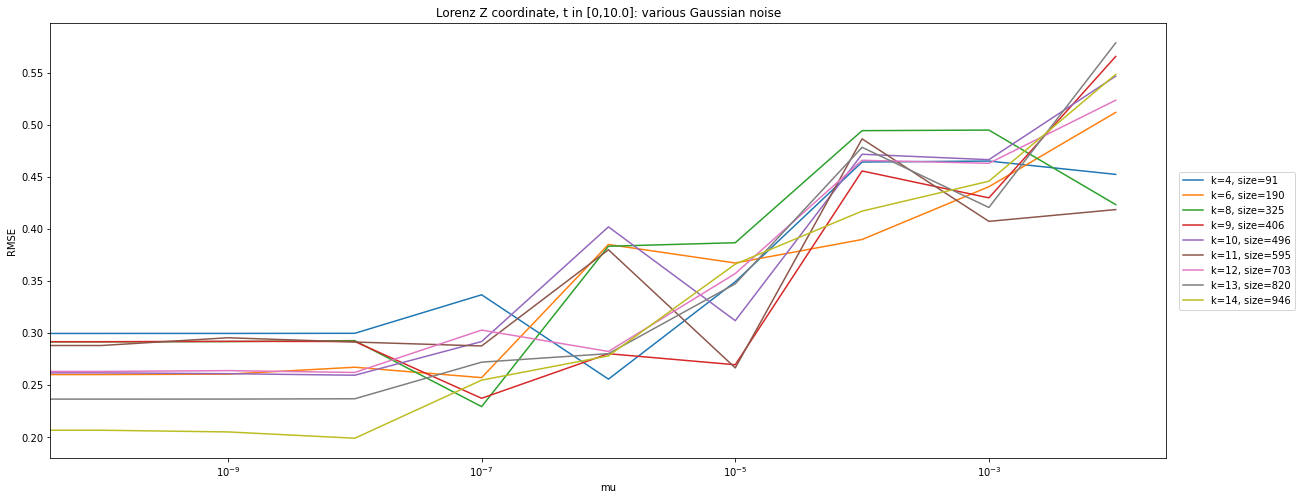

In [47]:
fig, axs = plt.subplots(1, figsize=(20, 8))
# axs.plot(lorenz_scaled[:num_pts,0], data[:num_pts,0], label="raw")
for i in range(len(k_arr)):
    axs.plot(mu_arr, rmse_matrix[i,:], label=f'k={k_arr[i]}, size={nvar_rows(3,k_arr[i])}')
axs.legend(loc="right", ncol=1, bbox_to_anchor=(1.12,0.5))
axs.set_xlabel('mu')
axs.set_ylabel('RMSE')
axs.set_xscale('log')
axs.set_title(f'Lorenz Z coordinate, t in [0,{lorenz_scaled[num_pts,0]}]: various Gaussian noise')
plt.show()

In [48]:
df = pd.DataFrame(rmse_matrix, index=[nvar_rows(3,x) for x in k_arr], columns=mu_arr)

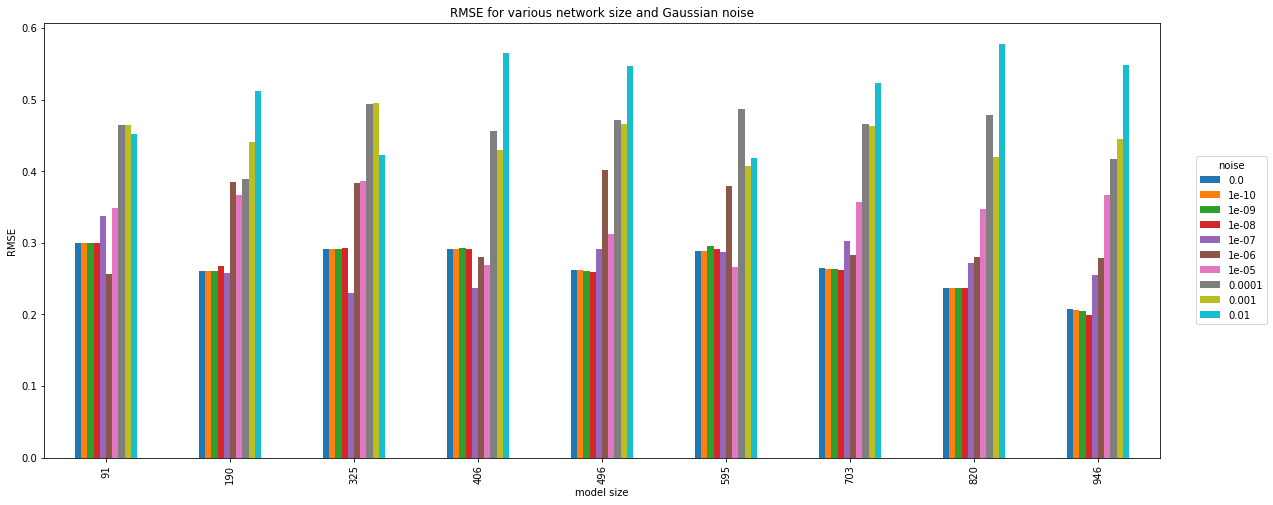

In [49]:
p = df.plot(kind='bar',figsize=(20,8), xlabel='model size', ylabel='RMSE', title='RMSE for various network size and Gaussian noise').legend(title='noise', loc="right", ncol=1, bbox_to_anchor=(1.1,0.5))